In This notebook, we load and investigate the S11 Measurements on the Greenbank feed.

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import scipy.signal as signal
import scipy.optimize as op

In [29]:
#First load in the data
dFile1='DATA03.d1'
dFile2='DATA04.d1'
d1=np.loadtxt(dFile1,skiprows=9,delimiter=',')[:-1,:]
d2=np.loadtxt(dFile2,skiprows=9,delimiter=',')[:-1,:]

dNominal=d1[:,0]+1j*d1[:,1]
dSuspect=d2[:,0]+1j*d2[:,1]
dNominal=dSuspect
freqAxis=100e6+np.arange(1600)*100e6/1600

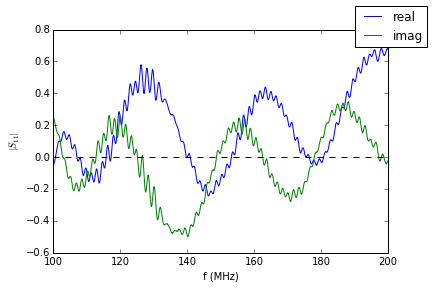

In [35]:
plt.close()
#plt.plot(freqAxis/1e6,np.sqrt(np.abs(d2[:,0])**2.+np.abs(d2[:,1])**2.),label='abs')
l1=plt.plot(freqAxis/1e6,np.real(dNominal),label='real')[0]
l2=plt.plot(freqAxis/1e6,np.imag(dNominal),label='imag')[0]
plt.axhline(0,color='k',ls='--')
plt.xlabel('f (MHz)')
plt.gcf().legend((l1,l2),('real','imag'),'upper right')
#plt.plot(freqAxis/1e6,.35+.1*np.sin(2*np.pi*freqAxis*30e-9))
plt.ylabel('$|S_{11}|$')
plt.savefig('../writeup/figures/s11.pdf')
plt.show()
delayAxis=fft.fftshift(fft.fftfreq(len(dNominal),100e6/1600.))

In [36]:
def fft1d(data):
    return fft.fftshift(fft.fft(fft.fftshift(data)))

def fft1d_pad(data):
    window=signal.blackmanharris(len(data))
    window=window/np.mean(window)
    dw=data*window
    #dw=np.pad(dw,((len(data),0)),mode='constant')
    return fft.fftshift(fft.ifft((dw)))

"""
def fft1d_pad(data):
    window=signal.blackmanharris(len(data))
    #window=np.hanning(len(data))
    window=window/np.sqrt(np.mean(window**2.))
    dw=data*window
    fwindow=fft.fftshift(fft.ifft(fft.fftshift(window)))
    #dw=np.pad(dw,((len(data),0)),mode='constant')
    dw=fft.fftshift(fft.ifft(fft.fftshift(dw)))
    delayAxis=np.arange(-800,800)/(100e6)
    plt.plot(delayAxis*1e9,np.abs(dw))
    plt.plot(delayAxis*1e9,np.abs(fwindow))
    plt.xlim(0,200)
    plt.yscale('log')
    plt.ylim(1e-3,1e0)
    gammaA=dw[len(dw)/2]
    return (dw)*(gammaA/(1.-gammaA))
"""

"\ndef fft1d_pad(data):\n    window=signal.blackmanharris(len(data))\n    #window=np.hanning(len(data))\n    window=window/np.sqrt(np.mean(window**2.))\n    dw=data*window\n    fwindow=fft.fftshift(fft.ifft(fft.fftshift(window)))\n    #dw=np.pad(dw,((len(data),0)),mode='constant')\n    dw=fft.fftshift(fft.ifft(fft.fftshift(dw)))\n    delayAxis=np.arange(-800,800)/(100e6)\n    plt.plot(delayAxis*1e9,np.abs(dw))\n    plt.plot(delayAxis*1e9,np.abs(fwindow))\n    plt.xlim(0,200)\n    plt.yscale('log')\n    plt.ylim(1e-3,1e0)\n    gammaA=dw[len(dw)/2]\n    return (dw)*(gammaA/(1.-gammaA))\n"

0.162260266412
0.301106263033
[ 0.24139971-0.17997544j]
[ 0.16226027]
[ 0.38203379]
[ 0.41704774  1.44560814]


/Users/aaronew/default/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: overflow encountered in power
/Users/aaronew/default/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in log10


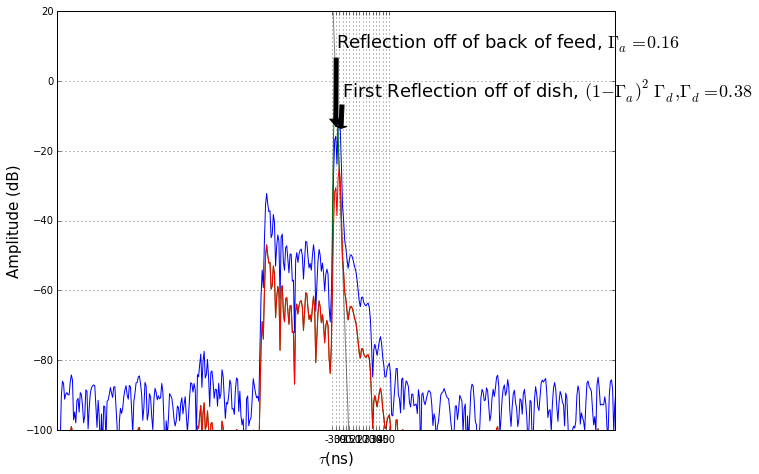

In [39]:
#first, let's play around with the fft
nominalFT=fft1d_pad(dNominal)

#let's find gamma_a and the dish

def windowedMax(data,select):
    dWindow=data[select]
    maxVal=np.abs(dWindow).max()
    print maxVal
    return data[np.abs(data)==maxVal]

selectGa=np.abs(delayAxis)<10e-9
gA=windowedMax(nominalFT,selectGa)
selectPeak=np.logical_and(delayAxis>10e-9,delayAxis<40e-9)
gPeak=windowedMax(nominalFT,selectPeak)
print gPeak
gD=gPeak/(1.-gA)**2.

print np.abs(gA)
print np.abs(gD)
#gD=.8
tConst=np.abs(gD*gA)


#now let's try correcting
dNominalCorrected=((dNominal-gA)*gA/(1.-gA)+1.-gA)
FTnominalCorrected=fft1d_pad(dNominalCorrected)
dNominalCorrectedOld=((dNominal))*gA/(1.-gA)
FTnominalCorrectedOld=fft1d_pad(dNominalCorrectedOld)

fitSelect=np.logical_and(delayAxis>60e-9,delayAxis<120e-9)
fitDelays=delayAxis[fitSelect]
fitVals=np.abs(nominalFT)[fitSelect]
gDFit,_=op.curve_fit(lambda x,a,b: a*b**x,(fitDelays-30e-9)/30e-9,fitVals,p0=[1.,np.abs(gA*gD)])
print np.abs(gDFit/gA)

#lm1=plt.plot(delayAxis*1e9,20*np.log10(np.abs(gDFit[0]*(gDFit[1]**((delayAxis-30e-9)/30e-9)))),':',color=[.3,.3,.3])
l0=plt.plot(delayAxis*1e9,20.*np.log10(np.abs((1-gA))*tConst**((delayAxis)/28e-9)),color=[.5,.5,.5])[0]
l2=plt.plot(delayAxis*1e9,20*np.log10(np.abs(nominalFT)),'-')[0]
l2=plt.plot(delayAxis*1e9,20*np.log10(np.abs(FTnominalCorrected)))[0]
l3=plt.plot(delayAxis*1e9,20*np.log10(np.abs(FTnominalCorrectedOld)))[0]
plt.ylim(-100,20)
#plt.yscale('log')
plt.xlim(-2500,2500)
plt.xlabel('$\\tau$(ns)',fontsize=15)
plt.ylabel('Amplitude (dB)',fontsize=15)
plt.gca().set_xticks(np.arange(-30,17*30,30))
labels=[]
ax=plt.gca()
for mm in range(len(plt.gca().get_xticks())):
    if(np.mod(mm,2)==0):
        labels.append(str(ax.get_xticks()[mm]))
    else:
        labels.append('')
ax.set_xticklabels(labels)
plt.grid()
plt.grid(b=True,which='minor')
ax.annotate('Reflection off of back of feed, $\\Gamma_a=%.2f$'%(np.abs(gA)), xy=(0, 20.*np.log10(.2)), xytext=(3, 20.*np.log10(3)),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=18
            )
ax.annotate('First Reflection off of dish, $(1-\\Gamma_a)^2\\Gamma_d,\\Gamma_d=%.2f$'%(np.abs(gD)), xy=(45, 20*np.log10(.2)), xytext=(56, 20.*np.log10(.6)),
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=18
            )
#predicted slow is .23*0.1 every 30 ns
#plt.gcf().legend((l1,l2,l3),('|$S_{11}$|','$(\\Gamma_a \\Gamma_d)^{(\\tau/30 ns)}$','Response Function'),'lower right')
#plt.legend((l1,l2,l3,l0),('|$S_{11}$|','Response Function','No DC term','Predicted Slope from Dish Amplitude','Fitted Slope \\Gamma_d = %.2f'%(gDFit[1]/np.abs(gA))),'center right',fontsize=14)
plt.gcf().set_size_inches([10,7.5])
plt.savefig('../writeup/figures/reflectometry.pdf')

In [12]:
def getDC(data):
    window=signal.blackmanharris(len(data))
    #window=np.hanning(len(data))
    window=window/np.sqrt(np.mean(window**2.))
    return fft.fftshift(fft.ifft(fft.fftshift(data*window)))[len(data)/2]

dComplex=d1[:,0]+1j*d1[:,1]
rFeed=getDC(dComplex)
#rData=(dComplex-rFeed)/(1./rFeed-1.)+(1-rFeed)
rData=(dComplex)/(1./rFeed-1.)


rFunction=np.abs(fft1d_pad(dComplex))

In [13]:
delays=fft.fftshift(fft.fftfreq(d2.shape[0],100e6/1600.))

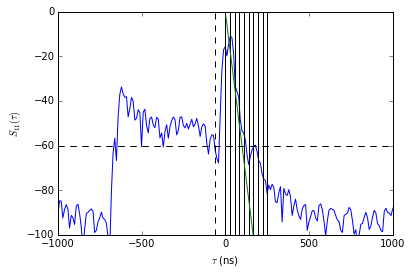

In [45]:
plt.plot(delays*1e9,2*10.*np.log10(rFunction))
#plt.plot(delays*1e9,2*10.*np.log10(np.abs(rFunctionRect)/np.abs(rFunctionRect).max()))

plt.xlabel('$\\tau$ (ns)')
plt.ylabel('$S_{11}(\\tau)$')
plt.xlim(-2000,2000)
plt.axhline(-60,color='k',ls='--')
plt.axvline(60,color='k',ls='--')


plt.axhline(-60,color='k',ls='--')
plt.axvline(-60,color='k',ls='--')
for mm in range(10):
    plt.axvline(mm*28,color='k',ls='-')
plt.plot(delays*1e9,-.6*delays*1e9)
plt.xlim(-1000,1000)
plt.ylim(-100,0)
#plt.gcf().set_size_inches(20,10)
plt.savefig('delayResponse_feedAndDish.pdf')